In [1]:
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
import pickle
import warnings 
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('../Data/X_train.csv')
y_train = pd.read_csv('../Data/y_train.csv')
X_test = pd.read_csv('../Data/X_test.csv')
y_test = pd.read_csv('../Data/y_test.csv')
X_oot = pd.read_csv('../Data/X_oot.csv')
y_oot = pd.read_csv('../Data/y_oot.csv')
y_train = y_train['Fraud']
y_test = y_test['Fraud']
y_oot = y_oot['Fraud']
X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_test = X_test.drop(['Unnamed: 0'], axis=1)
X_oot = X_oot.drop(['Unnamed: 0'], axis=1)

In [3]:
X_train.columns

Index(['Year', 'Day', 'Weekend', 'Amount', 'Avg_Transaction_Amount',
       'Amount_Deviation', 'Min_Amount', 'Max_Amount',
       'Merchant_Frequency_Week', 'Merchant_Frequency_Month',
       'Card_Frequency_Week', 'Card_Frequency_Month', 'Days_Since_Card_Seen',
       'Days_Since_Merchant_Appeared', 'Days_Since_Card_Merch_Combination',
       'Cardnum_0', 'Cardnum_1', 'Cardnum_2', 'Cardnum_3', 'Cardnum_4',
       'Cardnum_5', 'Cardnum_6', 'Cardnum_7', 'Cardnum_8', 'Cardnum_9',
       'Cardnum_10', 'Day_of_Week_0', 'Day_of_Week_1', 'Day_of_Week_2',
       'Month_0', 'Month_1', 'Month_2', 'Month_3', 'Merchnum_0', 'Merchnum_1',
       'Merchnum_2', 'Merchnum_3', 'Merchnum_4', 'Merchnum_5', 'Merchnum_6',
       'Merchnum_7', 'Merchnum_8', 'Merchnum_9', 'Merchnum_10', 'Merchnum_11',
       'Merchnum_12', 'Merchnum_13', 'Merch description_0',
       'Merch description_1', 'Merch description_2', 'Merch description_3',
       'Merch description_4', 'Merch description_5', 'Merch description_6

In [4]:
results = []


models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('XGBoost',xgb.XGBClassifier( objective="multi:softmax",num_class=3,max_depth=3,learning_rate=0.1,n_estimators=100,subsample=0.8,colsample_bytree=0.8,random_state=42))
    # Add more models here
]

In [5]:


for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_oot = model.predict(X_oot)
    # Calculate evaluation metrics
    accuracy_oot = accuracy_score(y_oot, y_pred_oot)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_oot = classification_report(y_oot, y_pred_oot, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']
    f1_score_oot = report_oot['macro avg']['f1-score']
    # Calculate confusion matrix values
    cm_oot = confusion_matrix(y_oot, y_pred_oot)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tn_oot, fp_oot, fn_oot, tp_oot = cm_oot.ravel()
    #mc_rate = (((fp+fn)/len())*100)
    #mc_rate_oot = (((fp_oot+fn_oot)/(tp_oot+fp_oot+tn_oot+fn_oot))*100)
    data = pd.DataFrame(X_test, columns=['Amount'])  # Include other columns if needed
    data_oot = pd.DataFrame(X_oot, columns=['Amount'])
    # Add predictions and true labels to the DataFrame
    data['predicted'] = y_pred
    data['actual'] = y_test
    data_oot['predicted'] = y_pred_oot
    data_oot['actual'] = y_oot 
    # Filter out true positive cases
    true_positives = data[(data['predicted'] == 1) & (data['actual'] == 1)]
    
    true_positives_oot = data_oot[(data_oot['predicted'] == 1) & (data_oot['actual'] == 1)]
    # Get the sum of amounts for true positives
    sum_amounts_true_positives = true_positives['Amount'].sum()
    sum_amounts_true_positives_oot = true_positives_oot['Amount'].sum()
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Create a DataFrame with actual and predicted values
    data = pd.DataFrame({'Actual': y_test, 'Predicted': y_probs})
    
    # Calculate FDR for regular data
    top_percentage = 0.03  # Top 3% of cases
    top_records = int(len(data) * top_percentage)
    
    # Sort by predicted probabilities in descending order
    data = data.sort_values(by='Predicted', ascending=False)
    
    # Select top percentage of records
    top_records_data = data.head(top_records)
    
    # Calculate FDR for regular data
    fraud_cases = sum(top_records_data['Actual'])
    FDR = fraud_cases / sum(data['Actual'])
    
    # Create a DataFrame with actual and predicted values for OOT data
    data_oot = pd.DataFrame({'Actual': y_oot, 'Predicted': model.predict_proba(X_oot)[:, 1]})
    
    # Calculate FDR for OOT data
    top_records_oot = int(len(data_oot) * top_percentage)
    data_oot = data_oot.sort_values(by='Predicted', ascending=False)
    top_records_data_oot = data_oot.head(top_records_oot)
    fraud_cases_oot = sum(top_records_data_oot['Actual'])
    FDR_oot = fraud_cases_oot / sum(data_oot['Actual'])
    
    # Create a dictionary with results
    model_results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        #'Miss_Classification_Rate':mc_rate,
        'Amount_Saved':sum_amounts_true_positives,
        'FDR': FDR,
        'Amount_saved_OOT': sum_amounts_true_positives_oot,
        'Accuracy OOT': accuracy_oot,
        'F1 Score OOT': f1_score_oot,
        #'Miss_Classification_Rate_OOT':mc_rate_oot,
        'FDR OOT': FDR_oot  # Add FDR for OOT data
    }
    
    # Append results to list
    results.append(model_results)
    
    print(model_name+' done')

# Convert results list to DataFrame
results_df = pd.DataFrame(results)


Logistic Regression done
Random Forest done
Support Vector Machine done
K-Nearest Neighbors done
XGBoost done


In [6]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,TP,FP,TN,FN,Amount_Saved,FDR,Amount_saved_OOT,Accuracy OOT,F1 Score OOT,FDR OOT
0,Logistic Regression,0.989443,0.744986,0.525295,0.543737,9,9,16486,167,95085.90,0.409091,27675.23,0.984376,0.534522,0.179775
1,Random Forest,0.998980,0.987630,0.962947,0.974961,163,4,16491,13,401741.57,1.000000,130336.37,0.991700,0.800229,0.932584
2,Support Vector Machine,0.990402,0.812513,0.607288,0.658600,38,22,16473,138,232044.26,0.687500,6239.56,0.985271,0.501755,0.297753
3,K-Nearest Neighbors,0.993642,0.882318,0.783182,0.825193,100,30,16465,76,306769.63,0.829545,29138.00,0.984051,0.558476,0.191011
4,XGBoost,0.997721,0.949945,0.939826,0.944826,155,17,16478,21,391393.04,0.988636,140065.52,0.993327,0.853946,0.938202


In [7]:
best_model_indice = results_df['F1 Score OOT'].idxmax()

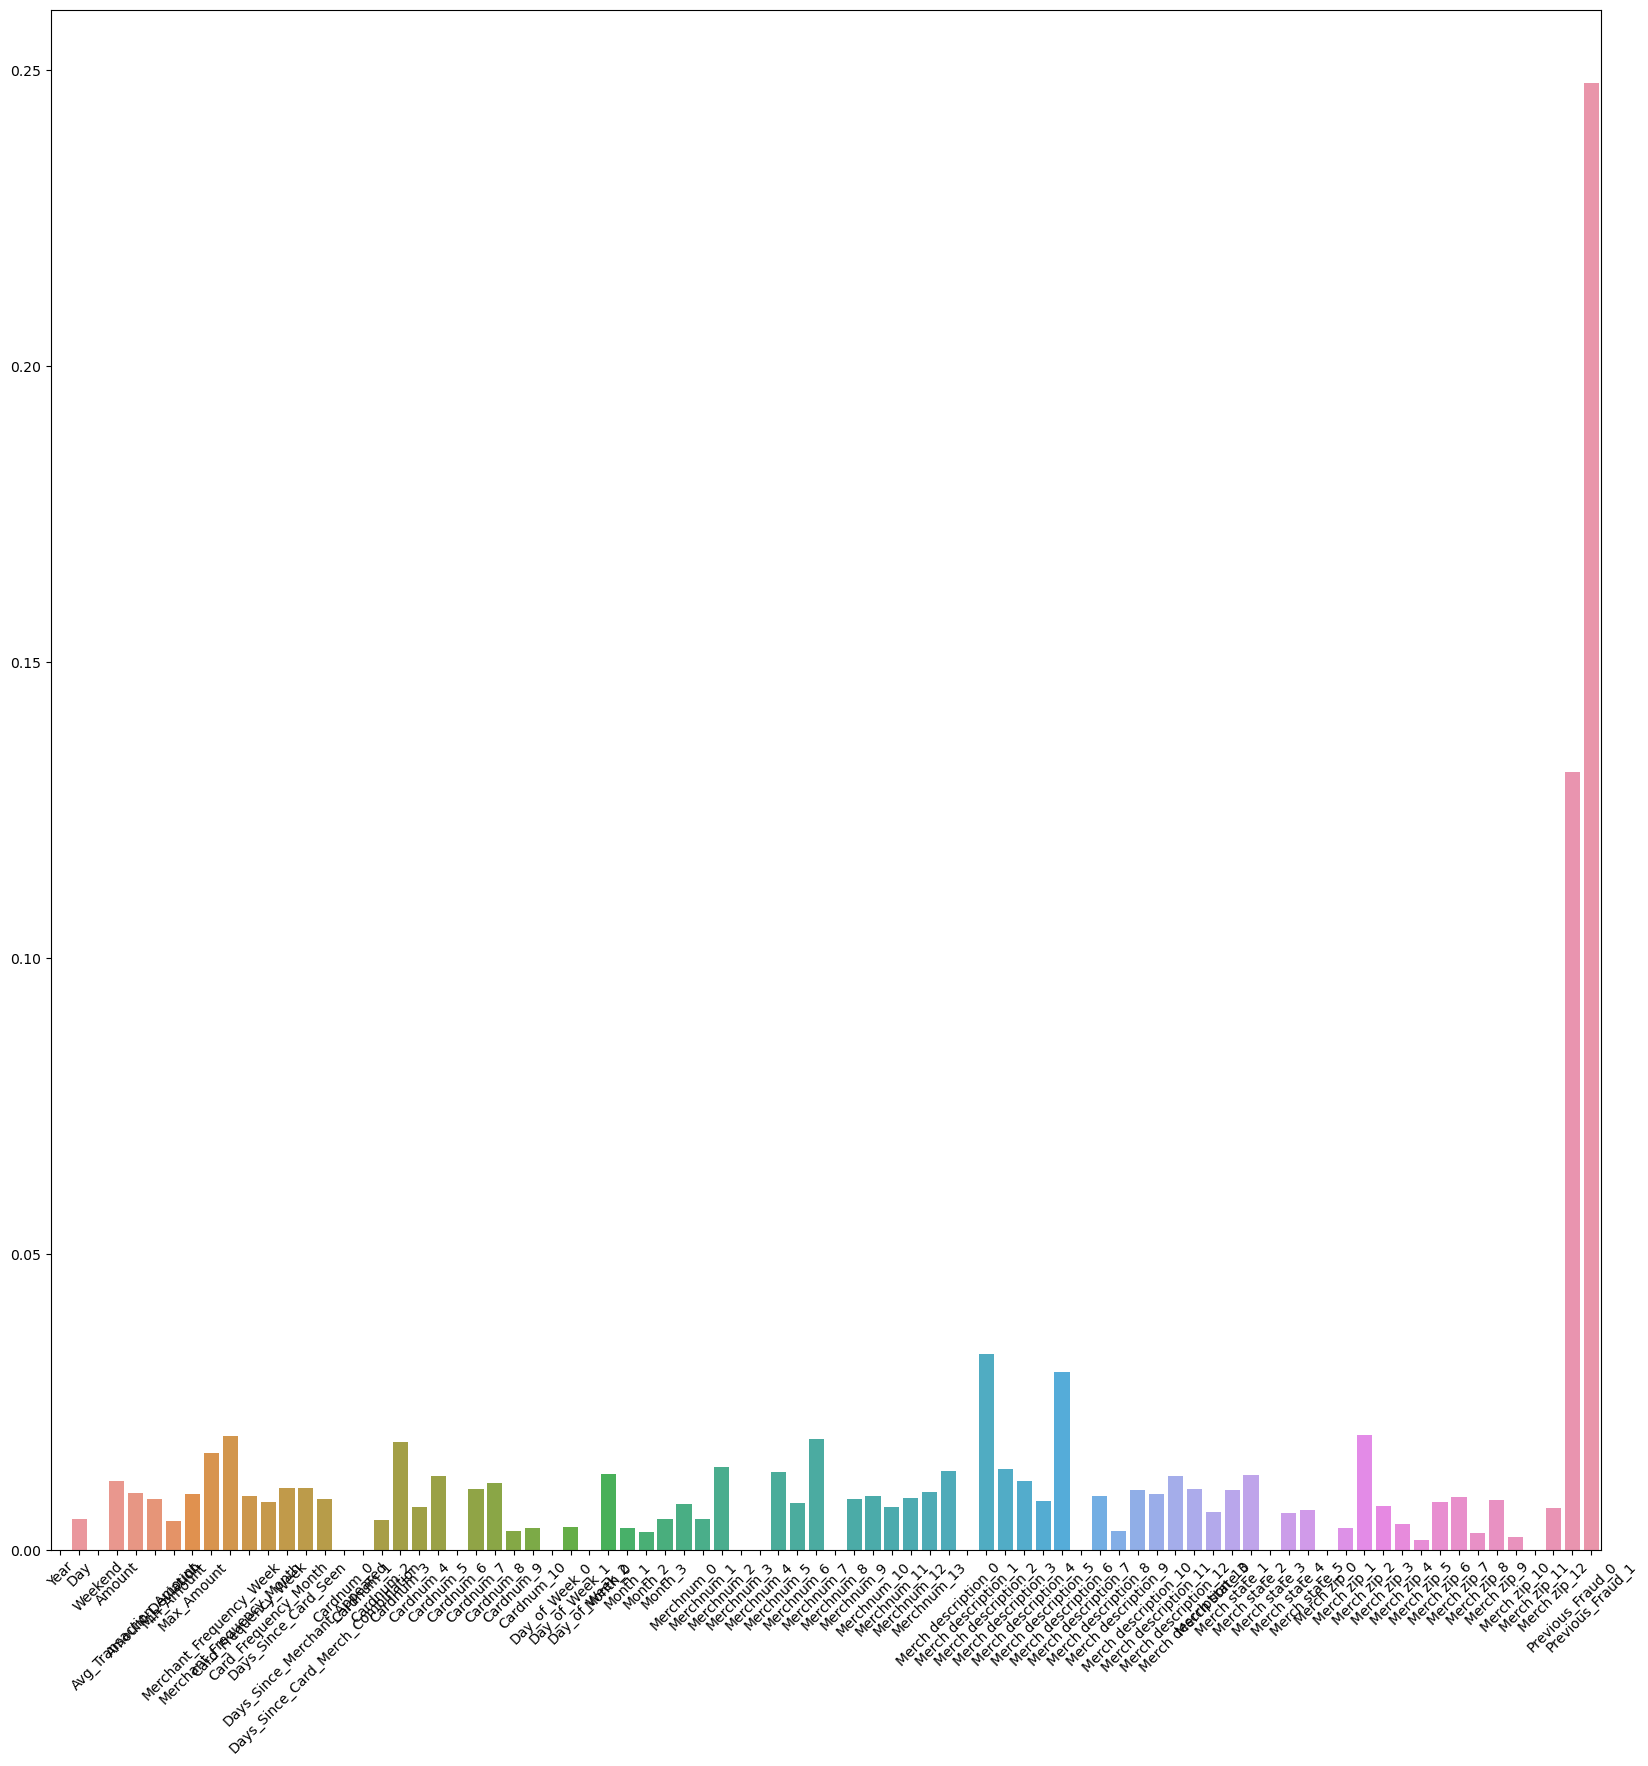

In [8]:
plt.figure(figsize=(20, 20))
sns.barplot(x=X_train.columns, y=models[best_model_indice][1].feature_importances_)
plt.xticks(rotation=45)
plt.savefig('../Images/ML Model Feature Importance.jpg')
plt.show()

In [9]:
with open('ML_Model.pkl', 'wb') as outfile:
    pickle.dump(models[best_model_indice][1], outfile)